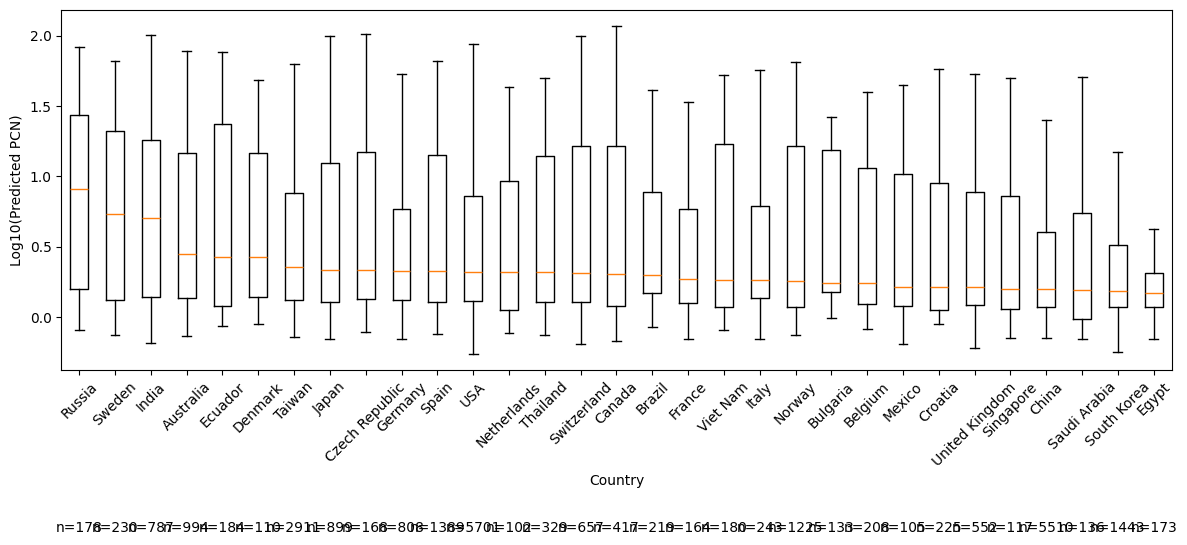

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load the file
file_path = "Figure_4_data.csv"
df = pd.read_csv(file_path)

# Step 2: Remove invalid or missing location entries
invalid_values = ['not determined', 'not collected', 'not available', '-', 'nan']
df_location = df[~df['Location'].isin(invalid_values) & df['Location'].notna()].copy()

# Count invalid and valid entries
missing_location_count = df['Location'].isin(invalid_values).sum()
present_location_count = len(df_location)

# Step 3: Extract country name from 'Location' (check for NaN or non-string values)
df_location['Country'] = df_location['Location'].apply(lambda x: str(x).split(':')[0].strip() if isinstance(x, str) else str(x))

# Step 4: Convert PCN column to numeric (if needed)
df_location['Predicted_PCN_backtransformed'] = pd.to_numeric(df_location['Predicted_PCN_backtransformed'], errors='coerce')

# Step 5: Take the log10 of the Predicted PCN values
df_location['Log10_PCN'] = np.log10(df_location['Predicted_PCN_backtransformed'].replace(0, np.nan))  # Avoid log(0)

# Step 6: Count plasmids per country
summary = df_location.groupby('Country').agg(
    Total_Plasmids=('Log10_PCN', 'count'),
    PCN_Greater_Than_10=('Log10_PCN', lambda x: (x > 1).sum()),  # Log10(10) = 1, so PCN > 10
    PCN_Less_Equal_Than_10=('Log10_PCN', lambda x: (x <= 1).sum())
).reset_index()

# Step 7: Filter for countries with at least 100 plasmids
filtered_group = summary[summary['Total_Plasmids'] >= 100].copy()  # Use .copy() to avoid view

# Step 8: Sort countries by median Log10(PCN) value from highest to lowest
filtered_group['Median_PCN'] = filtered_group['Country'].apply(lambda country: np.median(df_location[df_location['Country'] == country]['Log10_PCN']))
filtered_group = filtered_group.sort_values(by='Median_PCN', ascending=False)

# Step 9: Create Boxplot for countries with at least 100 plasmids (swapping axes)
plt.figure(figsize=(12, 6))

# Create the box plot excluding outliers and swapping axes
plt.boxplot([df_location[df_location['Country'] == country]['Log10_PCN'] for country in filtered_group['Country']],
            tick_labels=filtered_group['Country'], vert=True, showfliers=False)

# Add the count (n=) to the plot only once per country
for i, country in enumerate(filtered_group['Country']):
    count = filtered_group[filtered_group['Country'] == country]['Total_Plasmids'].values[0]
    plt.text(
        x=i + 1, y=-1.5,  # Adjust positioning for text
        s=f"n={count}",
        horizontalalignment='center', verticalalignment='center', fontsize=10
    )

# Rotate the x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.ylabel('Log10(Predicted PCN)')
plt.xlabel('Country')

# Save the plot
plt.tight_layout()
plt.savefig(f"{output_dir}S4_B.pdf", dpi=1200)

# Step 11: Show the plot
plt.show()
